In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np 
import matplotlib.pyplot as plt

## [An astronomer's introduction to `NumPyro` by Dan Foreman-Mackey](https://dfm.io/posts/intro-to-numpyro/)

- Basic documents:
    - [`Jax` Quickstart](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html)
    - [`NumPyro` documentation](https://num.pyro.ai/en/stable/)
    - [`Blackjack` documentation](https://blackjax-devs.github.io/blackjax/)
    
- Also see [Mixture Models by Dan Foreman-Mackey](https://dfm.io/posts/mixture-models/)

- [Bayesian Regression Using `NumPyro`](https://num.pyro.ai/en/stable/tutorials/bayesian_regression.html)

### `Jax` Quickstart

In [37]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

In [3]:
key = random.PRNGKey(0)

size = 5000 
x = random.normal(key, (size, size), dtype=jnp.float32)

In [4]:
%timeit jnp.dot(x, x.T).block_until_ready()

394 ms ± 8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
def selu(x, alpha=1.67, lmbda=1.06):
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha) 

x = random.normal(key, (2000000,))

%timeit selu(x).block_until_ready()

2.83 ms ± 61.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
selu_jit = jit(selu)

%timeit selu_jit(x).block_until_ready()

679 µs ± 9.08 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [7]:
def sum_logistic(x):
    return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))
                   
x_small = jnp.arange(3.) 
                   
d_fn = grad(sum_logistic)

print(d_fn(x_small))

[0.25       0.19661197 0.10499357]


In [8]:
print(grad(jit(grad(jit(grad(sum_logistic)))))(1.0))

-0.0353256


### Example 1: Linear regression with outliers

In [9]:
true_frac = 0.7 # Outlier fraction 

# The linear model has unit slope and zero intercept:
true_params = [0.9, 0.0]

# The outliers are drawn from a Gaussian with zero mean and unit variance:
true_outliers = [0.0, 1.0]

np.random.seed(86)
x = np.sort(np.random.uniform(-2, 2, 20))
yerr = 0.2 * np.ones_like(x)

y = true_params[0] * x + true_params[1] + yerr * np.random.randn(len(x)) 

In [10]:
# Replace some of the data with outliers
m_bkg = np.random.rand(len(x)) > true_frac

y[m_bkg] = true_outliers[0]
y[m_bkg] += np.sqrt(true_outliers[1] + yerr[m_bkg] ** 2) * np.random.randn(sum(m_bkg))

# Then save the *true* line.
x0 = np.linspace(-2.1, 2.1, 200)
y0 = np.dot(np.vander(x0, 2), true_params)

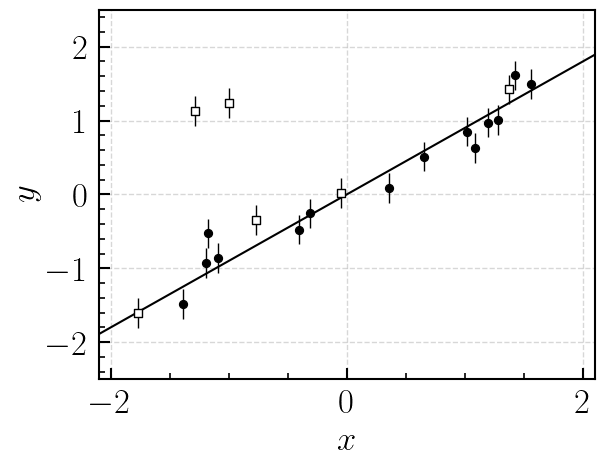

In [11]:
def plot_data():
    plt.errorbar(x, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
    plt.scatter(x[m_bkg], y[m_bkg], marker="s", s=32, c="w", edgecolor="k", zorder=1000)
    plt.scatter(
        x[~m_bkg], y[~m_bkg], marker="o", s=32, c="k", zorder=1000, label="data"
    )
    plt.plot(x0, y0, color="k", lw=1.5)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.ylim(-2.5, 2.5)
    plt.xlim(-2.1, 2.1)


plot_data()

#### Simple linear model using `Numpyro`

- We’ll parameterize our model using the angle of the line above horizontal $\theta=\arctan m$ ($m$ is the slope) and the perpendicular intercept $b_{\perp}=b \cos \theta$ ($b$ is the intercept). See [Jake VanderPlas's blog post](https://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/) about this parameterization. 

- [`numpyro.deterministic`](https://num.pyro.ai/en/stable/primitives.html#deterministic)
- [`numpyro.plate`](https://num.pyro.ai/en/stable/primitives.html#plate)
- [`numpyro.infer.Predictive`](https://num.pyro.ai/en/v0.2.0/utilities.html#predictive)

In [12]:
import numpyro
from numpyro import distributions as dist, infer

import arviz as az
import corner

numpyro.set_host_device_count(2)

In [13]:
def linear_model(x, yerr, y=None):
    # Parameters
    theta = numpyro.sample("theta", dist.Uniform(-0.5 * jnp.pi, 0.5 * jnp.pi))
    b_perp = numpyro.sample("b_perp", dist.Normal(-1, 1))

    # Transformed parameters (and other things!) can be tracked during sampling using "deterministics" as follows
    m = numpyro.deterministic("m", jnp.tan(theta))
    b = numpyro.deterministic("b", b_perp / jnp.cos(theta))
    
    # It's good to get into the habit of using plates because some inference 
    # algorithms or distributions can take advantage of knowing this structure.
    with numpyro.plate("data", len(x)):
        numpyro.sample("y", dist.Normal(m * x + b, yerr), obs=y)

In [14]:
# Using the model above, we can now sample from the posterior distribution 
# using the No U-Turn Sampler (NUTS).

sampler = infer.MCMC(
    infer.NUTS(linear_model),
    num_warmup=2000,
    num_samples=4000,
    num_chains=3,
    progress_bar=True,
)

# pass the observed data as a keyword argument to let us reuse the same model for predictive tasks.

%time sampler.run(random.PRNGKey(0), x, yerr, y=y)

/var/folders/jh/02q43k0x5tggt_fghykc1pbw0000gn/T/ipykernel_68684/4172786123.py:4: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = infer.MCMC(
sample: 100%|███████████████████████████| 6000/6000 [00:00<00:00, 12240.93it/s, 11 steps of size 9.02e-01. acc. prob=0.91]


CPU times: user 3.19 s, sys: 90.3 ms, total: 3.28 s
Wall time: 3.28 s


In [15]:
# It’s always a good idea to check the convergence of your MCMC sampler, and we’ll use ArviZ to do that here, 
# looking at the Gelman–Rubin (r_hat) statistic, and the effective sample sizes (e.g. ess_bulk):

inf_data = az.from_numpyro(sampler)
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b,0.238,0.045,0.154,0.321,0.0,0.0,11598.0,8442.0,1.0
b_perp,0.198,0.037,0.127,0.267,0.0,0.0,11408.0,8278.0,1.0
m,0.663,0.040,0.587,0.736,0.0,0.0,11034.0,8269.0,1.0
theta,0.585,0.028,0.534,0.637,0.0,0.0,11034.0,8269.0,1.0


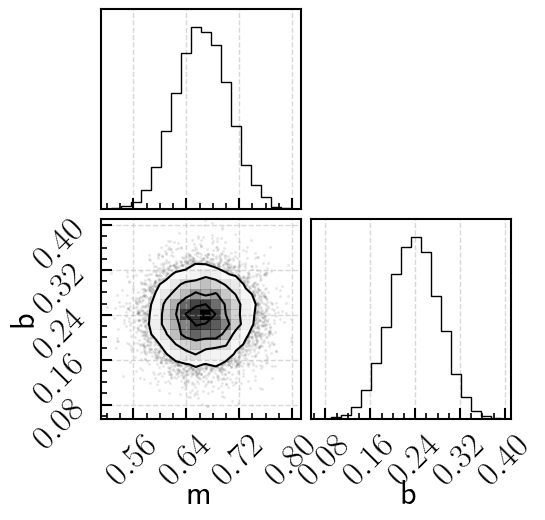

In [16]:
corner.corner(inf_data, var_names=["m", "b"], truths=true_params);

In [18]:
len(x)

20

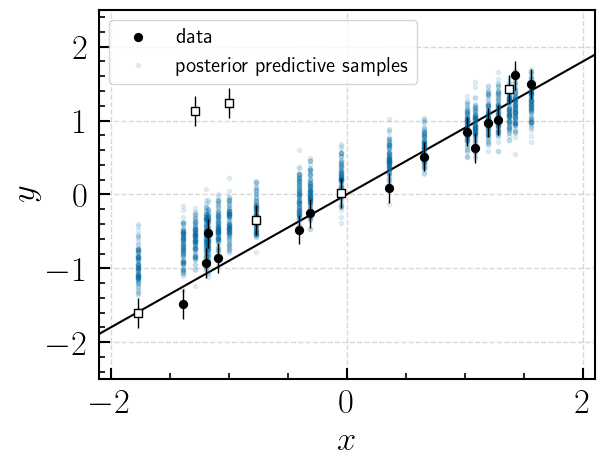

In [20]:
post_pred_samples = infer.Predictive(
    linear_model, sampler.get_samples())(
        random.PRNGKey(1), x, yerr
)

post_pred_y = post_pred_samples["y"]

plot_data()
label = "posterior predictive samples"

for n in np.random.default_rng(0).integers(len(post_pred_y), size=100):
    plt.plot(x, post_pred_y[n], ".", color="C0", alpha=0.1, label=label)
    label=None
plt.legend(fontsize=15, loc='best');

In [21]:
post_pred_samples

{'b': Array([0.20597933, 0.26371524, 0.24010995, ..., 0.2658232 , 0.185031  ,
        0.22829154], dtype=float32),
 'm': Array([0.6422806 , 0.7092995 , 0.6629756 , ..., 0.64239484, 0.6150422 ,
        0.59055007], dtype=float32),
 'y': Array([[-0.7092769 , -0.76464427, -1.0588306 , ...,  0.6251438 ,
          1.088319  ,  1.1082289 ],
        [-1.3206887 , -0.8855239 , -0.33990243, ...,  1.4432648 ,
          1.2462871 ,  1.29201   ],
        [-1.0716597 , -0.754225  , -0.46737528, ...,  1.2728338 ,
          1.2315018 ,  1.2341214 ],
        ...,
        [-0.7194862 , -0.6366969 , -0.40736264, ...,  1.2268468 ,
          1.287687  ,  1.066226  ],
        [-0.98942703, -0.683149  , -0.53090376, ...,  1.2292275 ,
          1.0548302 ,  0.90955323],
        [-1.1059644 , -1.0463384 , -0.5375405 , ...,  1.1063097 ,
          0.9092717 ,  0.82874644]], dtype=float32)}

In [23]:
post_pred_samples['y'].shape

(12000, 20)

#### Using a mixture model to account for the outliers

- [Blog post about Mixture Models](https://dfm.io/posts/mixture-models/)

- Model setup:
    - "Foreground" model: the same with above
    - "Background" model: a Gaussian with a floating mean and standard deviation.
    - $Q$: mixture weight.

For mixture models:
    - `numpyro` has [`MixtureSameFamily`](https://num.pyro.ai/en/stable/distributions.html#mixturesamefamily) that supports a finite mixture of component distributions from the same family. 
    - `numpyro` also has [`MixtureGeneral`](https://num.pyro.ai/en/stable/distributions.html#mixturegeneral) for a finite mixture of component distributions from different families. 

In [24]:
from numpyro.distributions import MixtureGeneral

In [31]:
def linear_mixture_model(x, yerr, y=None):
    # Foreground model
    
    ## Parameters
    theta = numpyro.sample("theta", dist.Uniform(-0.5 * jnp.pi, 0.5 * jnp.pi))
    b_perp = numpyro.sample("b_perp", dist.Normal(-1, 1))

    ## Transformed parameters (and other things!) can be tracked during sampling using "deterministics" as follows
    m = numpyro.deterministic("m", jnp.tan(theta))
    b = numpyro.deterministic("b", b_perp / jnp.cos(theta))
    
    ## Don't wrap the actual sampling distribution in a `numpyro.sample` here because 
    ## we're going to use it in the mixture distribution below.
    fg_dist = dist.Normal(m * x + b, yerr) 
    
    # Outlier model:
    bg_mean = numpyro.sample("bg_mean", dist.Normal(0.0, 1.0))
    bg_sigma = numpyro.sample("bg_sigma", dist.HalfNormal(5.0))
    bg_dist = dist.Normal(bg_mean, jnp.hypot(bg_sigma, yerr))
    
    # Using a `Categorical` distribution to define the outlier probability. 
    # Fit for the parameter Q which specifies the probability that a data point is not an outlier. 
    # So the prior probability for outlier is 1 - Q
    Q = numpyro.sample("Q", dist.Uniform(0.0, 1.0))
    mix = dist.Categorical(probs=jnp.array([Q, 1.0 - Q]))
    
    with numpyro.plate("data", len(x)):
        numpyro.sample("obs", MixtureGeneral(mix, [fg_dist, bg_dist]), obs=y)
    

In [32]:
sampler = infer.MCMC(
    infer.NUTS(linear_mixture_model),
    num_warmup=4000,
    num_samples=6000,
    num_chains=3,
    progress_bar=True
)

%time sampler.run(random.PRNGKey(3), x, yerr, y=y)

/var/folders/jh/02q43k0x5tggt_fghykc1pbw0000gn/T/ipykernel_68684/3532669573.py:1: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = infer.MCMC(
sample: 100%|██████████████████████████| 10000/10000 [00:01<00:00, 9803.53it/s, 15 steps of size 3.32e-01. acc. prob=0.90]

CPU times: user 4.36 s, sys: 53 ms, total: 4.41 s
Wall time: 4.4 s


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Q,0.815,0.096,0.637,0.975,0.001,0.001,12495.0,8987.0,1.0
b,0.025,0.052,-0.078,0.118,0.000,0.000,12495.0,10749.0,1.0
b_perp,0.019,0.040,-0.055,0.094,0.000,0.000,12502.0,10702.0,1.0
bg_mean,0.827,0.604,-0.448,1.742,0.007,0.005,8425.0,7431.0,1.0
bg_sigma,0.961,1.142,0.000,2.909,0.012,0.008,7766.0,6869.0,1.0
m,0.856,0.049,0.764,0.950,0.000,0.000,13163.0,9846.0,1.0
theta,0.707,0.029,0.652,0.760,0.000,0.000,13163.0,9846.0,1.0


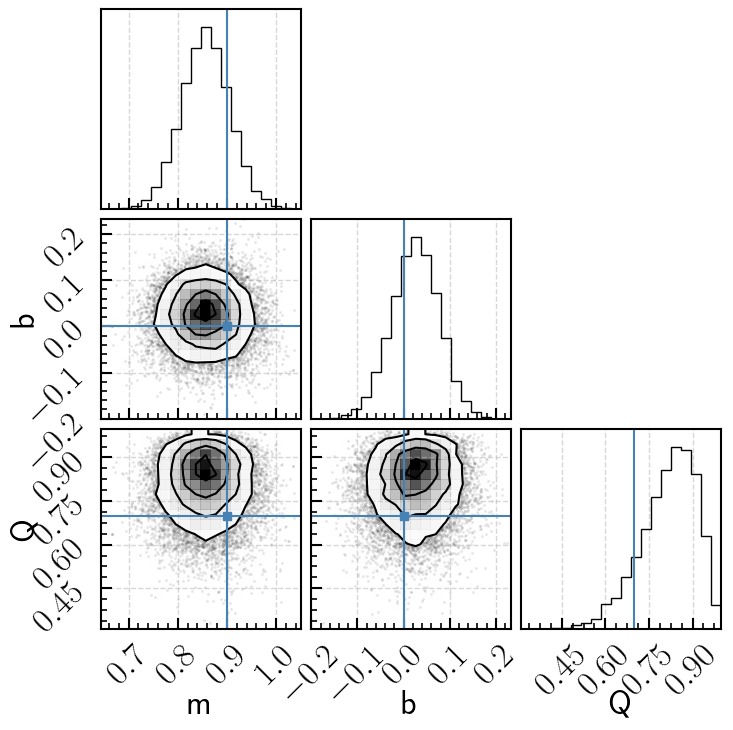

In [33]:
inf_data = az.from_numpyro(sampler)

corner.corner(
    inf_data,
    var_names=["m", "b", "Q"],
    truths={
        "m": true_params[0],
        "b": true_params[1],
        "Q": true_frac,
    },
)

az.summary(inf_data)

#### Identify the outliers

In [34]:
def linear_mixture_member_prob_model(x, yerr, y=None):
    # Foreground model 
    theta = numpyro.sample("theta", dist.Uniform(-0.5 * jnp.pi, 0.5 * jnp.pi))
    b_perp = numpyro.sample("b_perp", dist.Normal(0.0, 1.0))
    
    m = numpyro.deterministic("m", jnp.tan(theta))
    b = numpyro.deterministic("b", b_perp / jnp.cos(theta))
    
    fg_dist = dist.Normal(m * x + b, yerr)
    
    # Background model
    bg_mean = numpyro.sample("bg_mean", dist.Normal(0.0, 1.0))
    bg_sigma = numpyro.sample("bg_sigma", dist.HalfNormal(3.0))
    
    bg_dist = dist.Normal(bg_mean, jnp.hypot(bg_sigma, yerr))
    
    # Mixture weight
    Q = numpyro.sample("Q", dist.Uniform(0.0, 1.0))
    
    # Mixture model 
    mixture = MixtureGeneral(
        dist.Categorical(probs=jnp.array([Q, 1.0 - Q])), [fg_dist, bg_dist]
    )
    
    with numpyro.plate("data", len(x)):
        
        y_ = numpyro.sample("obs", mixture, obs=y)

        # Probability that the object is not an outlier.
        log_probs = mixture.component_log_probs(y_)
        
        numpyro.deterministic(
            "p", log_probs - jax.nn.logsumexp(log_probs, axis=-1, keepdims=True)
        )

In [38]:
sampler = infer.MCMC(
    infer.NUTS(linear_mixture_member_prob_model), 
    num_warmup=4000, 
    num_samples=6000, 
    num_chains=3, 
    progress_bar=True
)

%time sampler.run(random.PRNGKey(3), x, yerr, y=y)

/var/folders/jh/02q43k0x5tggt_fghykc1pbw0000gn/T/ipykernel_68684/2784872278.py:1: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = infer.MCMC(
sample: 100%|███████████████████████████| 10000/10000 [00:01<00:00, 9579.29it/s, 7 steps of size 3.23e-01. acc. prob=0.91]

CPU times: user 4.77 s, sys: 81.1 ms, total: 4.86 s
Wall time: 4.84 s


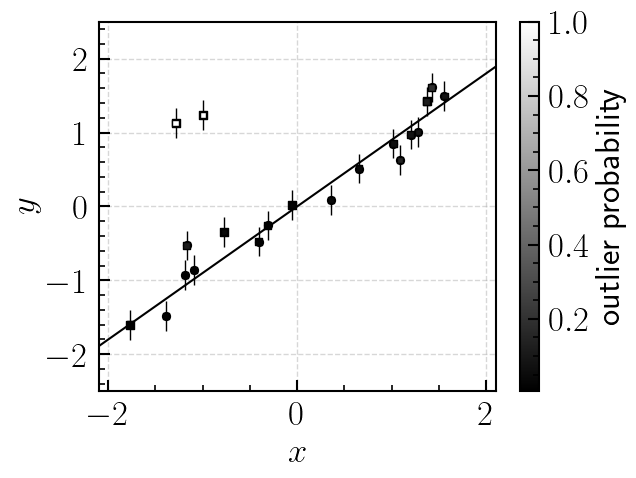

In [39]:
p_fg = jnp.mean(jnp.exp(sampler.get_samples()["p"][..., 0]), axis=0)

plot_data()
plt.scatter(x, y, marker="s", s=22, c=1 - p_fg, edgecolor="k", zorder=1000, cmap="gray")
plt.colorbar(label="outlier probability");